In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import gc

from utils.schemas import *

In [4]:
data_folder = 'input'

In [5]:
train = pd.read_csv(data_folder+'/train_generated_0.csv', dtype = schema_generated_0)
test = pd.read_csv(data_folder+'/test_generated_0.csv', dtype = schema_generated_0)

In [8]:
train.shape, test.shape

((590540, 552), (506691, 552))

In [9]:
train.head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,id_36_fe2,id_37_fe2,id_38_fe2,proc_id_30_1_fe2,proc_id_30_0_fe2,R_emaildomain_0_fe2,proc_id_31_0_fe2,P_emaildomain_1_fe2,R_emaildomain_1_fe2,P_emaildomain_0_fe2
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,2
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,8
3,2.0,0.0,1.0,0.0,25.0,1.0,5.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1,1,2,4,7,0,8,0,0,0


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
import lightgbm as lgb

In [13]:
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

In [20]:
train.Transaction_hour.value_counts()

19.0    42115
20.0    41782
21.0    41641
18.0    41639
22.0    41139
17.0    40723
23.0    39949
16.0    38698
0.0     37795
15.0    33859
1.0     32797
14.0    28328
2.0     26732
3.0     20802
13.0    20315
4.0     14839
12.0    12451
5.0      9701
11.0     6827
6.0      6007
7.0      3704
10.0     3627
8.0      2591
9.0      2479
Name: Transaction_hour, dtype: int64

In [33]:
a = train.groupby([x for x in train.columns if 'card' in x and 'fe' not in x]).count()['TransactionDT']
a.name = 'N1'
a.head(20)

card1  card2  card3  card4  card5  card6
0      7      0      1      2      0         8844
                            12     0         6047
       12     2      4      11     2           41
1      0      0      0      0      0        14112
       12     2      4      11     2           50
2      6      1      0      5      0        10332
       12     2      4      11     2           29
3      0      0      0      0      0        10312
       12     2      4      11     2           32
4      5      0      1      3      1         7918
       12     2      4      11     2           27
5      4      0      0      0      1         6766
       12     2      4      11     2            5
6      3      0      0      0      0         7079
       12     2      4      11     2           12
7      0      0      0      0      0         6760
       12     2      4      11     2           13
8      12     2      4      11     2           15
       16     0      0      0      0         6126
9      12

In [29]:
a.name = 'N1'

In [30]:
a.head()

card1  card2  card3  card4  card5  card6
0      7      0      1      2      0         8844
                            12     0         6047
       12     2      4      11     2           41
1      0      0      0      0      0        14112
       12     2      4      11     2           50
Name: N1, dtype: int64

In [44]:
cols1 = [x for x in train.columns if 'card' in x and 'fe' not in x]
group1 = train.groupby(cols1).count()['TransactionDT']
group1.name = 'N1'
train2 = train.join(group1, on=cols1)

In [45]:
train2.head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,proc_id_30_1_fe2,proc_id_30_0_fe2,R_emaildomain_0_fe2,proc_id_31_0_fe2,P_emaildomain_1_fe2,R_emaildomain_1_fe2,P_emaildomain_0_fe2,Transaction_day_of_week,Transaction_hour,N1
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,2,0.0,0.0,6
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0.0,0.0,678
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,8,0.0,0.0,1104
3,2.0,0.0,1.0,0.0,25.0,1.0,5.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,4197
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,4,7,0,8,0,0,0,0.0,0.0,18


In [49]:
cols1 = [x for x in train.columns if 'addr' in x]
group1 = train2.groupby(cols1).count()['TransactionDT']
group1.name = 'N2'
train2 = train2.join(group1, on=cols1)

In [56]:
cols1 = [x for x in train.columns if 'C' in x]
group1 = train2.groupby(cols1).count()['TransactionDT']
group1.name = 'N3'
train2 = train2.join(group1, on=cols1)

In [62]:
cols1 = [x for x in train.columns if 'mail' in x]
group1 = train2.groupby(cols1).count()['TransactionDT']
group1.name = 'N4'
train2 = train2.join(group1, on=cols1)

In [63]:
train2.head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,proc_id_31_0_fe2,P_emaildomain_1_fe2,R_emaildomain_1_fe2,P_emaildomain_0_fe2,Transaction_day_of_week,Transaction_hour,N1,N2,N3,N4
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,1,0,2,0.0,0.0,6,23077,164,83392
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0.0,0.0,678,42748,11291,176504
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,8,0.0,0.0,1104,26284,41367,2707
3,2.0,0.0,1.0,0.0,25.0,1.0,5.0,0.0,0.0,0.0,...,0,0,0,1,0.0,0.0,4197,9476,6,91013
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,8,0,0,0,0.0,0.0,18,3581,8000,176504


In [58]:
import seaborn as sns
%matplotlib inline
sns.set(style="ticks")

LinAlgError: singular matrix

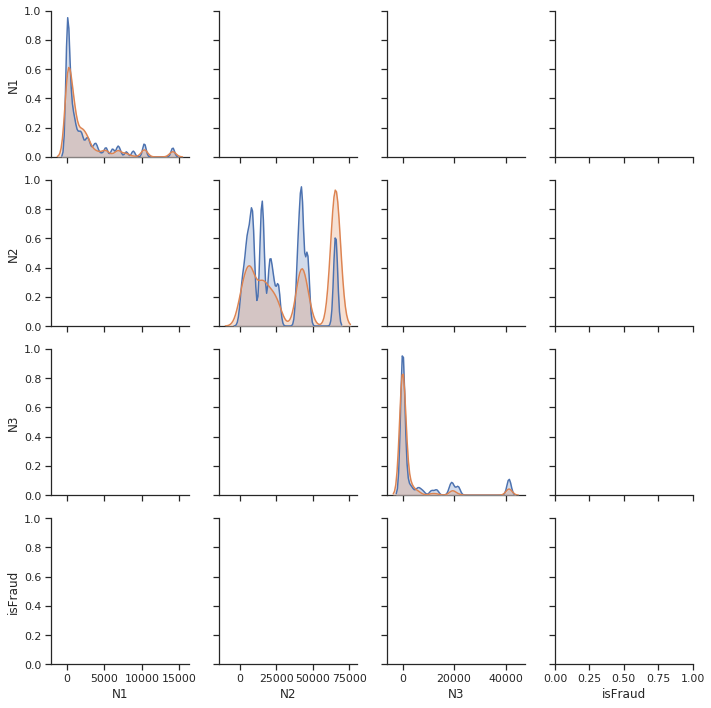

In [59]:
sns.pairplot(train2[['N1','N2','N3','isFraud']], hue="isFraud")

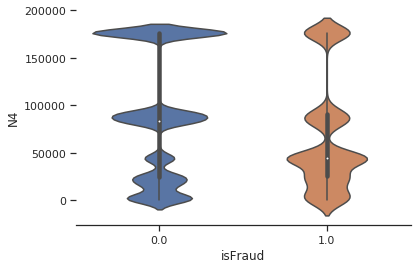

In [65]:
sns.violinplot(x="isFraud", y="N4",
               split=True,
               data=train2)
sns.despine(left=True)

In [28]:
def custom_loss(y_pred, y_true):
    precision, recall, thresholds = precision_recall_curve(np.where(y_true >= 0.5, 1, 0), y_pred)
    AUC = auc(recall, precision)
    if AUC != AUC:
        AUC = 0
    return 'PR_AUC', AUC, True

In [40]:
params = {
    'max_depth': 13,
    'metric': ['PR_AUC'],
    'first_metric_only': True,
    'n_estimators': 20000,
    'learning_rate': 0.05,
    'colsample_bytree': 0.8,
    'objective': 'xentropy',
    'n_jobs': -1,
    'seed': 42,
    'bagging_fraction': 0.8,
    'lambda_l1': 0,
    'lambda_l2': 0,
}

In [41]:
lgb_model = lgb.LGBMClassifier(**params)

In [30]:
X_cols = [x for x in df_imputed2.columns if x not in ['isFraud', 'TransactionDT', 'TransactionID']]

In [132]:
# df_imputed2_1 = df_imputed2[df_imputed2.isFraud==1]
# df_imputed2_0 = df_imputed2[df_imputed2.isFraud==0].sample(frac=0.3)
# X = pd.concat([df_imputed2_1, df_imputed2_0])[X_cols]
# y = pd.concat([df_imputed2_1, df_imputed2_0]).isFraud

In [32]:
X = df_imputed2[X_cols].iloc[:train_index, :]
y = df_imputed2.isFraud[:train_index]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
lgb_model.fit(X_train,
                   y_train,
                   eval_set=[(X_test, y_test)],
                   verbose=50,
                   early_stopping_rounds=50,
                   eval_metric=custom_loss
                  )

LightGBMError: GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1

In [111]:
n_round = lgb_model.best_iteration_
n_round

2038

In [113]:
params = {
    'max_depth': 13,
    'metric': ['PR_AUC'],
    'first_metric_only': True,
    'n_estimators': int(n_round*1.1),
    'learning_rate': 0.05,
    'colsample_bytree': 0.8,
    'objective': 'xentropy',
    'n_jobs': -1,
    'seed': 42,
    'bagging_fraction': 0.8,
    'lambda_l1': 0,
    'lambda_l2': 0,
}

In [114]:
lgb_model = lgb.LGBMClassifier(**params)

In [115]:
lgb_model.fit(X, y, verbose=100)

LGBMClassifier(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.8, first_metric_only=True,
        importance_type='split', lambda_l1=0, lambda_l2=0,
        learning_rate=0.05, max_depth=13, metric=['PR_AUC'],
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=2241, n_jobs=-1, num_leaves=31, objective='xentropy',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [44]:
del X_train
del X_test
del y_train
del y_test

In [45]:
gc.collect()

8

In [139]:
X_test = df_imputed2[X.columns].iloc[train_index:, :]

In [140]:
y_preds = lgb_model.predict_proba(X_test)

In [141]:
y_preds[:,1]

array([0.00095012, 0.00021622, 0.00047366, ..., 0.00846984, 0.01005928,
       0.00357157])

In [142]:
df_sub = pd.read_csv(data_folder+'/sample_submission.csv')

In [143]:
df_sub['isFraud'] = y_preds[:,1]

In [144]:
df_sub.head()

,TransactionID,isFraud
0,3663549,0.000950
1,3663550,0.000216
2,3663551,0.000474
3,3663552,0.003246
4,3663553,0.002967


In [145]:
df_sub.to_csv('submissions/benchmark_freq_enc_3_30porciento_sincard1.csv', sep=',', header=True, index=None)

In [146]:
df_imp = pd.DataFrame({'ft': X.columns, 'imp': lgb_model.feature_importances_}).sort_values('imp', ascending=False)

In [147]:
df_imp.head(30)

,ft,imp
385,card2,1895
43,TransactionAmt,1722
383,addr1,1595
20,D15,1027
422,id_31,1012
4,C13,919
390,dist1,800
15,D10,751
388,card5,723
23,D4,671


In [254]:
import datetime

In [264]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
X_train = pd.DataFrame()
X_train['TransactionDT'] = train_imputed['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

X_train['year'] = X_train['TransactionDT'].dt.year
X_train['month'] = X_train['TransactionDT'].dt.month
X_train['dow'] = X_train['TransactionDT'].dt.dayofweek
X_train['hour'] = X_train['TransactionDT'].dt.hour
X_train['day'] = X_train['TransactionDT'].dt.day
print('hello world')

In [265]:
X_train.head(30)

,TransactionDT,year,month,dow,hour,day
0,2017-12-02 00:00:00,2017,12,5,0,2
1,2017-12-02 00:00:01,2017,12,5,0,2
2,2017-12-02 00:01:09,2017,12,5,0,2
3,2017-12-02 00:01:39,2017,12,5,0,2
4,2017-12-02 00:01:46,2017,12,5,0,2
5,2017-12-02 00:01:50,2017,12,5,0,2
6,2017-12-02 00:02:02,2017,12,5,0,2
7,2017-12-02 00:02:09,2017,12,5,0,2
8,2017-12-02 00:02:15,2017,12,5,0,2
9,2017-12-02 00:02:16,2017,12,5,0,2
